In [17]:
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!sh local_setup.sh
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

Compiling pyrossgeo/_simulation.pyx because it changed.
[1/1] Cythonizing pyrossgeo/_simulation.pyx
running build_ext
building 'pyrossgeo._simulation' extension
gcc -pthread -B /home/lukas/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/lukas/anaconda3/lib/python3.7/site-packages/numpy/core/include -I/home/lukas/anaconda3/include/python3.7m -c pyrossgeo/_simulation.cpp -o build/temp.linux-x86_64-3.7/pyrossgeo/_simulation.o -std=c++11
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/lukas/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /home/lukas/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/lukas/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from pyrossgeo/_simulatio

Simulation settings

In [18]:
t_start = 0
t_end = 24*60*700

_, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  1*60),
    (7*60,  1),
    (10*60, 2*60),
    (17*60, 1),
    (19*60, 2*60)
], end_time=24*60)

In [12]:
%load_ext cython

In [ ]:
%%cython

# distutils: language = c++
# distutils: extra_compile_args = -std=c++11

cdef extern from "<random>" namespace "std":
    cdef cppclass mt19937:
        mt19937() # we need to define this constructor to stack allocate classes in Cython
        mt19937(unsigned int seed) # not worrying about matching the exact int type for seed

    cdef cppclass poisson_distribution[T]:
        poisson_distribution()
        poisson_distribution(double a)
        T operator()(mt19937 gen) # ignore the possibility of using other classes for "gen"
        
cdef mt19937 gen = mt19937(5)
cdef poisson_distribution[int] dist = poisson_distribution[int](2)

print(dist(gen))

In [16]:
import scipy.stats

scipy.stats.poisson.rvs(100000000000)

99999586784

Run simulation

In [21]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize()
dX_state = np.zeros(X_state.size)

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1)

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

## Plot data

Text(0.5, 0, 'Days')

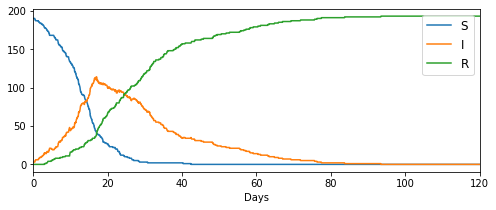

In [26]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize()
dX_state = np.zeros(X_state.size)

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1)

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
I = np.sum(network_data[:,:,1], axis=1)
R = np.sum(network_data[:,:,2], axis=1)
N = S + I + R

s = ts_days > 150
s = ts_days > 0

plt.plot(ts_days, S, label="S")
plt.plot(ts_days[s], I[s], label="I")
plt.plot(ts_days, R, label="R")
#plt.plot(ts_days, N, label="N")

plt.legend(loc='upper right', fontsize=12)
plt.xlim(0, 120)
#plt.ylim(0, 30)
plt.xlabel('Days')

Text(0.5, 0, 'Days')

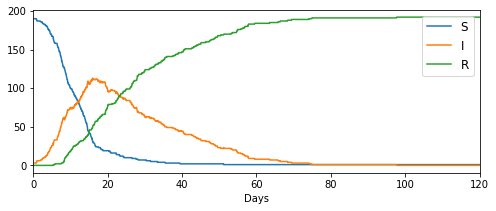

In [22]:
plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
I = np.sum(network_data[:,:,1], axis=1)
R = np.sum(network_data[:,:,2], axis=1)
N = S + I + R

s = ts_days > 150
s = ts_days > 0

plt.plot(ts_days, S, label="S")
plt.plot(ts_days[s], I[s], label="I")
plt.plot(ts_days, R, label="R")
#plt.plot(ts_days, N, label="N")

plt.legend(loc='upper right', fontsize=12)
plt.xlim(0, 120)
#plt.ylim(0, 30)
plt.xlabel('Days')

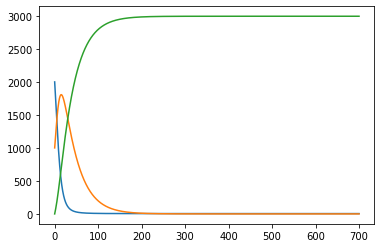

In [5]:
min_in_days = 60*24
beta = 0.18 / min_in_days
gamma = 0.03 / min_in_days

s = 2000
i = 1000
r = 0
n = s + i + r

dt = 0.1
ss = [s]
ii = [i]
rr = [r]
tt = [0]

t = 0

for t in np.arange(t_start+dt, t_end, dt):
    ds = ( -beta*i*s/n )
    di = ( beta*i*s/n - gamma*i)
    dr = (gamma*i)
    
    s += ds*dt
    i += di*dt
    #print(s+ds*dt)
    r += dr*dt

    ss.append(s)
    ii.append(i)
    rr.append(r)
    tt.append(t)
    
tt_days = np.array(tt) / min_in_days
    
plt.plot(tt_days, ss, label="S")
plt.plot(tt_days, ii, label="I")
plt.plot(tt_days, rr, label="R")

In [6]:
plt.plot(tt_days, ss, label="S")
plt.plot(tt_days, ii, label="I")
plt.plot(tt_days, rr, label="R")

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

Error in callback <function flush_figures at 0x7f4ae6fd6680> (for post_execute):


KeyboardInterrupt: 

In [7]:
print("ss = {%s};" %  ",".join(map(str, S)))
print("ii = {%s};" %  ",".join(map(str, I)))
print("rr = {%s};" %  ",".join(map(str, R)))
print("ts = {%s};" %  ",".join(map(str, ts_days)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
plt.figure( figsize=(14,7) )

S0 = network_data[:,0,0]
I0 = network_data[:,0,1]
R0 = network_data[:,0,2]
S1 = network_data[:,1,0]
I1 = network_data[:,1,1]
R1 = network_data[:,1,2]
S2 = network_data[:,2,0]
I2 = network_data[:,2,1]
R2 = network_data[:,2,2]
S3 = network_data[:,3,0]
I3 = network_data[:,3,1]
R3 = network_data[:,3,2]

plt.plot(ts_days, S0, label="S0")
plt.plot(ts_days, I0, label="I0")
plt.plot(ts_days, R0, label="R0")
plt.plot(ts_days, S1, label="S1")
plt.plot(ts_days, I1, label="I1")
plt.plot(ts_days, R1, label="R1")
plt.plot(ts_days, S2, label="S2")
plt.plot(ts_days, I2, label="I2")
plt.plot(ts_days, R2, label="R2")
plt.plot(ts_days, S3, label="S3")
plt.plot(ts_days, I3, label="I3")
plt.plot(ts_days, R3, label="R3")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')

IndexError: index 3 is out of bounds for axis 1 with size 3

<Figure size 1008x504 with 0 Axes>